现在读取csv数据文件，其中包含了计划在全球投资组合中包括的资产类别的历史收益数据，以及关于每个资产类 别的基于市值的权重数据。使用的输入文件可以通过以下两个链接下载

In [16]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
asset_returns_orig = pd.read_csv('asset_returns.csv',index_col='Year',parse_dates=True)
asset_weights = pd.read_csv('asset_weights.csv', index_col='asset_class')
cols = ['Global Bonds (Unhedged)','Total US Bond Market','US Large Cap Growth',
'US Large Cap Value','US Small Cap Growth','US Small Cap Value','Emerging Markets',
'Intl Developed ex-US Market','Short Term Treasury']
asset_returns = asset_returns_orig[cols].dropna()
treasury_rate = asset_returns['Short Term Treasury']
asset_returns = asset_returns[cols[:-1]].astype(float).dropna()
asset_weights = asset_weights.loc[cols[:-1]]

In [17]:
print(asset_returns.mean())
print(asset_weights)

Global Bonds (Unhedged)        0.059615
Total US Bond Market           0.054231
US Large Cap Growth            0.131538
US Large Cap Value             0.102308
US Small Cap Growth            0.119615
US Small Cap Value             0.114615
Emerging Markets               0.100000
Intl Developed ex-US Market    0.063462
dtype: float64
                             weight
asset_class                        
Global Bonds (Unhedged)       0.224
Total US Bond Market          0.077
US Large Cap Growth           0.163
US Large Cap Value            0.162
US Small Cap Growth           0.022
US Small Cap Value            0.022
Emerging Markets              0.030
Intl Developed ex-US Market   0.299


In [18]:
excess_asset_returns = asset_returns.subtract(treasury_rate, axis=0)
cov = excess_asset_returns.cov()
global_return = excess_asset_returns.mean().multiply(asset_weights['weight'].values).sum()
# market_var = np.matmul(asset_weights.values.reshape(len(asset_weights)).T,np.matmul(cov.values,asset_weights.values.reshape(len(asset_weights))))
# 使用@进行矩阵相乘，使得代码更加简洁美观
market_var = asset_weights.values.reshape(len(asset_weights)).T @ cov.values @ asset_weights.values.reshape(len(asset_weights))
print(f'The global market mean return is {global_return:.4f} and the variance is{market_var:.6}' )
risk_aversion = global_return / market_var
print(f'The risk aversion parameter is {risk_aversion:.2f}')

The global market mean return is 0.0446 and the variance is0.0202548
The risk aversion parameter is 2.20


对投资组合的权重进行反向工程，以获得隐含的均衡回报向量

In [19]:
def implied_rets(risk_aversion, sigma, w):
    implied_rets = risk_aversion * sigma.dot(w).squeeze()
    return implied_rets
implied_equilibrium_returns = implied_rets(risk_aversion, cov, asset_weights)
print(implied_equilibrium_returns)

Global Bonds (Unhedged)        0.012871
Total US Bond Market           0.002439
US Large Cap Growth            0.060436
US Large Cap Value             0.051548
US Small Cap Growth            0.056798
US Small Cap Value             0.043902
Emerging Markets               0.076184
Intl Developed ex-US Market    0.063076
Name: weight, dtype: float64


In [20]:
Q=np.array([0.0925,0.005,0.055])
P = np.asarray([[0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, .85, -.85, .15, -.15, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1]])
view1_var = P[0].reshape(len(P[0])) @ cov.values @ P[0].reshape(len(P[0])).T 
view2_var = P[1].reshape(len(P[1])) @ cov.values @ P[1].reshape(len(P[1])).T 
view3_var = P[2].reshape(len(P[2])) @ cov.values @ P[2].reshape(len(P[2])).T

In [21]:
print(f'The Variance of View 1 Portfolio is {view1_var}, and the standard deviation is {np.sqrt(view1_var):.3f}\n',\
      f'The Variance of View 2 Portfolio is {view2_var}, and the standard deviationis {np.sqrt(view2_var):.3f}\n',\
      f'The Variance of View 3 Portfolio is {view3_var}, and the standard deviation is {np.sqrt(view3_var):.3f}')

The Variance of View 1 Portfolio is 0.09655215384615386, and the standard deviation is 0.311
 The Variance of View 2 Portfolio is 0.014389680384615404, and the standard deviationis 0.120
 The Variance of View 3 Portfolio is 0.04505784615384616, and the standard deviation is 0.212


In [22]:
def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * cov).dot(P.T)))
    return matrix
tau = 0.025
omega = error_cov_matrix(cov, tau, P)
print(omega)

[[0.0024138  0.         0.        ]
 [0.         0.00035974 0.        ]
 [0.         0.         0.00112645]]


In [23]:
sigma_scaled = cov * tau
BL_return_vector = implied_equilibrium_returns + sigma_scaled @ P.T @ (inv(P @ sigma_scaled @ P.T + omega) @ (Q - P @ implied_equilibrium_returns))
print(BL_return_vector)

Global Bonds (Unhedged)        0.013157
Total US Bond Market           0.002431
US Large Cap Growth            0.057505
US Large Cap Value             0.050891
US Small Cap Growth            0.056636
US Small Cap Value             0.044942
Emerging Markets               0.079098
Intl Developed ex-US Market    0.062403
dtype: float64


In [32]:
returns_table = pd.concat([implied_equilibrium_returns, BL_return_vector], axis=1) * 100
returns_table.columns = ['Implied Returns', 'BL Return Vector']
returns_table['Difference'] = returns_table['BL Return Vector'] - returns_table['Implied Returns']
returns_table.style.format('{:,.2f}%')

,Implied Returns,BL Return Vector,Difference
Global Bonds (Unhedged),1.29%,1.32%,0.03%
Total US Bond Market,0.24%,0.24%,-0.00%
US Large Cap Growth,6.04%,5.75%,-0.29%
US Large Cap Value,5.15%,5.09%,-0.07%
US Small Cap Growth,5.68%,5.66%,-0.02%
US Small Cap Value,4.39%,4.49%,0.10%
Emerging Markets,7.62%,7.91%,0.29%
Intl Developed ex-US Market,6.31%,6.24%,-0.07%


In [25]:
inverse_cov = pd.DataFrame(inv(cov.values), index=cov.columns, columns=cov.index)
BL_weights_vector = inverse_cov.dot(BL_return_vector)
BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)

In [33]:
MV_weights_vector = inverse_cov.dot(excess_asset_returns.mean())
MV_weights_vector = MV_weights_vector/sum(MV_weights_vector)
weights_table = pd.concat([BL_weights_vector, asset_weights, MV_weights_vector],axis=1) * 100
weights_table.columns = ['BL Weights', 'Market Cap Weights', 'Mean-Var Weights']
weights_table['BL/Mkt Cap Diff'] = weights_table['BL Weights'] - weights_table['Market Cap Weights']
pd.options.display.float_format = '{:.2f}%'.format
print(weights_table.to_markdown(index=False))

|   BL Weights |   Market Cap Weights |   Mean-Var Weights |   BL/Mkt Cap Diff |
|-------------:|---------------------:|-------------------:|------------------:|
|     22.6852  |                 22.4 |          -13.9883  |         0.285244  |
|      7.79805 |                  7.7 |          107.264   |         0.0980525 |
|     10.0581  |                 16.3 |           17.539   |        -6.24191   |
|     22.8558  |                 16.2 |          -19.0549  |         6.65576   |
|      1.08987 |                  2.2 |           -1.82441 |        -1.11013   |
|      3.36616 |                  2.2 |           16.4268  |         1.16616   |
|      9.41748 |                  3   |            6.39127 |         6.41748   |
|     22.7293  |                 29.9 |          -12.7535  |        -7.17066   |


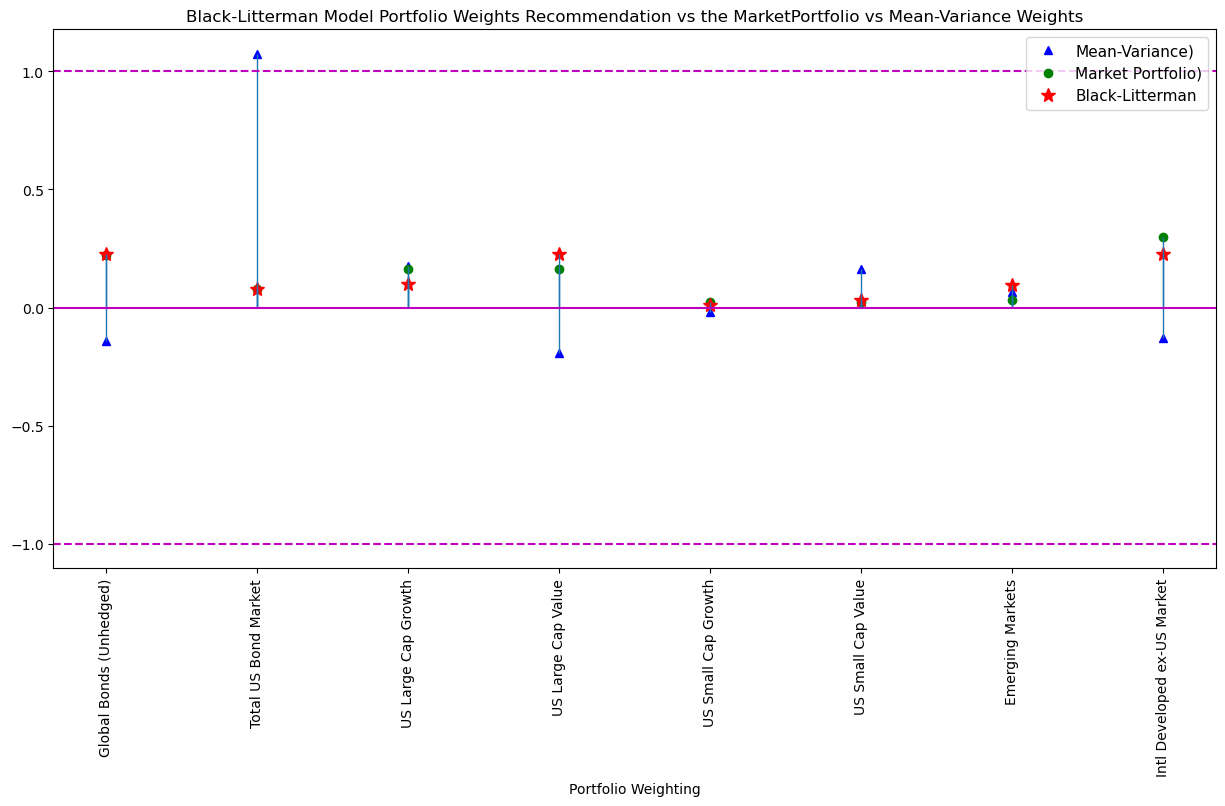

In [27]:
import matplotlib.pyplot as plt
N = BL_weights_vector.shape[0]
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Black-Litterman Model Portfolio Weights Recommendation vs the MarketPortfolio vs Mean-Variance Weights')
ax.plot(np.arange(N)+1, MV_weights_vector, '^', c='b', label='Mean-Variance)')
ax.plot(np.arange(N)+1, asset_weights, 'o', c='g', label='Market Portfolio)')
ax.plot(np.arange(N)+1, BL_weights_vector, '*', c='r',markersize=10, label='Black-Litterman')
ax.vlines(np.arange(N)+1, 0, BL_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, MV_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, asset_weights, lw=1)
ax.axhline(0, c='m')
ax.axhline(-1, c='m', ls='--')
ax.axhline(1, c='m', ls='--')
ax.set_xlabel('Assets')
ax.set_xlabel('Portfolio Weighting')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
ax.set_xticklabels(asset_weights.index.values)
plt.xticks(rotation=90, )
plt.legend(numpoints=1, fontsize=11)
plt.show()